In part 1, we ourselves created the additional features (x^2, x^3). Wouldn't it be nice if we create activation functions to do just that and let the neural network decide the weights for connections during training.
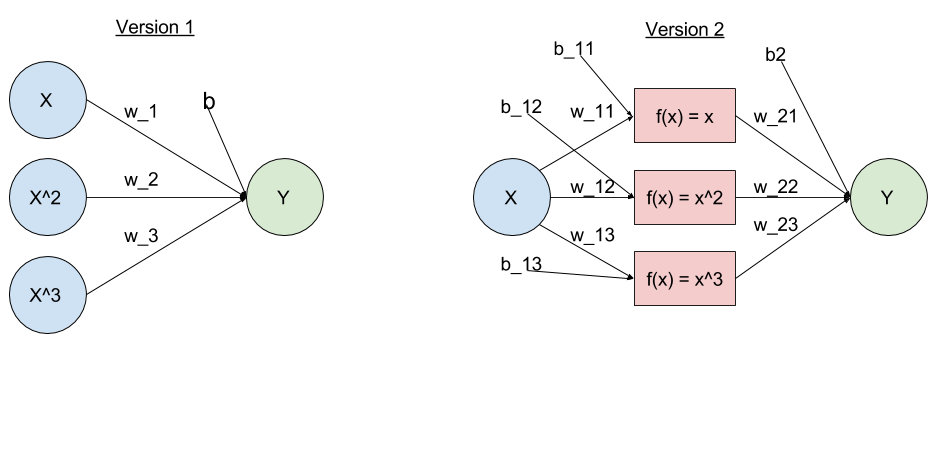

In [200]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [216]:
# Setup the training and test tensors
# Let's generate 400 examples
N = 400
x = np.random.uniform(low=-75, high=100, size=N)
y = 2*x

X_tensor = Variable(torch.FloatTensor(x), requires_grad=False)
y_tensor = Variable(torch.FloatTensor(y), requires_grad=False)

# Test set initialization
x_test = np.array([-2.5, 0.0, 19])
X_test_tsr = Variable(torch.FloatTensor(x_test), requires_grad=False)

# Normalized features
X_min = torch.min(X_tensor)
X_max = torch.max(X_tensor)
X_mean = torch.mean(X_tensor)
X_sub_mean = X_tensor-X_mean.expand_as(X_tensor)
X_max_min = X_max-X_min + 1e-7
X_norm_tsr = X_sub_mean/X_max_min.expand_as(X_sub_mean)

X_test_sub_mean = X_test_tsr-X_mean.expand_as(X_test_tsr)
X_test_norm_tsr = X_test_sub_mean/X_max_min.expand_as(X_test_sub_mean)

In [202]:
# Implement version-2 neural network
import math
from time import time
from collections import OrderedDict

def RunV2NNTraining(X, y, model, learning_rate=1e-5, epochs=5000, batch_size=None, X_test=None, 
                        use_optimizer=None, adam_betas=(0.9, 0.999)):
    # Neural Net
    X_size = X.size()
    N = X_size[0]
    
    loss_fn = torch.nn.MSELoss(size_average=True)
    
    # Choose Optimizer
    optimizer = None
    if use_optimizer:
        if use_optimizer == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=adam_betas)
        elif use_optimizer == 'Adadelta':
            optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'ASGD':
            optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'RMSprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'Adagrad':
            optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
        else:
            print("Invalid Optimizer")
            use_optimizer=None
    
    losses = []
    loss = None
    start_time = time()
    for t in range(epochs):
        num_batches = 1
        X_batch = None
        y_batch = None
        if batch_size:
            num_batches = math.ceil(N/batch_size)
        else:
            batch_size = N
        
        shuffle = torch.randperm(N)
        
        for b in range(num_batches):
            lower_index = b*batch_size
            upper_index = min(lower_index+batch_size, N)
            indices = shuffle[lower_index:upper_index]
            X_batch = X[indices]
            y_batch = y[indices]
                        
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            if use_optimizer:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                # Zero the gradients before running the backward pass.
                model.zero_grad()
                loss.backward()

                # Update the weights using gradient descent. Each parameter is a Variable, so
                # we can access its data and gradients like we did before.
                for param in model.parameters():
                    param.data -= learning_rate * param.grad.data
        losses.append(loss.data[0])

    end_time = time()
    time_taken = end_time - start_time
    print("Time Taken = %.2f seconds " % time_taken)
    print("Final Loss: ", loss.data[0])
    print("Parameters [w_1, w_2, w_3, b]: ")
    
    for name, param in model.named_parameters():
        print(name)
        print(param.data)

    # plot Loss vs Iterations
    plt.plot(losses)
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    
    # Predictions on Test set
    if X_test:
        print("Test:")
        print("X_test: ", X_test.data)
        print("y_pred: ", model(X_test))
        
def GetV2NNLoss(X, y, model):
    loss_fn = torch.nn.MSELoss(size_average=True)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    return loss.data[0]

### Time to create our x^n activation function

In [203]:
class PowerNet(torch.nn.Module):
    def __init__(self, n):
        super(PowerNet, self).__init__()
        self.n = n
        self.linear = torch.nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x).pow(self.n)

Pow123Net_Mask = Variable(torch.FloatTensor([1.0,1.0,1.0]), requires_grad=False)
class Pow123Net(torch.nn.Module):
    def __init__(self):
        super(Pow123Net, self).__init__()
        self.p1 = PowerNet(1)
        self.p2 = PowerNet(2)
        self.p3 = PowerNet(3)
        
    def forward(self, x):
        x1 = self.p1.forward(x)
        x2 = self.p2.forward(x)
        x3 = self.p3.forward(x)
        xc = torch.cat((x1, x2, x3), 1)
        return xc*Pow123Net_Mask.expand_as(xc)

### Unnormalized features

Time Taken = 15.20 seconds 
Final Loss:  1.1636777097479012e-09
Parameters [w_1, w_2, w_3, b]: 
Pow123Net.p1.linear.weight

-2.2046
[torch.FloatTensor of size 1x1]

Pow123Net.p1.linear.bias

 0.2074
[torch.FloatTensor of size 1]

Pow123Net.p2.linear.weight

 0.2494
[torch.FloatTensor of size 1x1]

Pow123Net.p2.linear.bias

-0.6614
[torch.FloatTensor of size 1]

Pow123Net.p3.linear.weight

-0.5029
[torch.FloatTensor of size 1x1]

Pow123Net.p3.linear.bias

-0.3687
[torch.FloatTensor of size 1]

FC.weight

-9.0721e-01 -2.6831e-07 -2.1332e-09
[torch.FloatTensor of size 1x3]

FC.bias

 0.1882
[torch.FloatTensor of size 1]



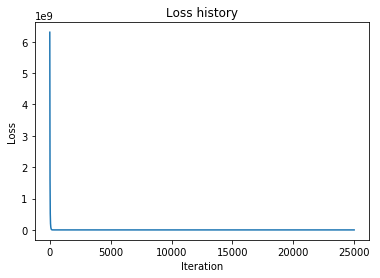

Test:
X_test:  
 -2.5000
  0.0000
 19.0000
[torch.FloatTensor of size 3x1]

y_pred:  Variable containing:
-5.0000e+00
 4.4525e-05
 3.8000e+01
[torch.FloatTensor of size 3x1]



In [206]:
# use_optimizer can be Adam, RMSprop, Adadelta, ASGD, SGD, Adagrad
model = torch.nn.Sequential(OrderedDict([
            ("Pow123Net", Pow123Net()),
            ("FC", torch.nn.Linear(3, 1))]
        ))
RunV2NNTraining(X=X_tensor.view(-1,1), y=y_tensor, model=model, batch_size=None, epochs=25000, learning_rate=5e-3, 
                    X_test=X_test_tsr.view(-1,1), use_optimizer='Adam')

In [217]:
# Now, how do we find the equation?
# One way to find is to see the effect of each activation on the loss
print("Final Loss: ", GetV2NNLoss(X=X_tensor.view(-1,1), y=y_tensor, model=model))

# mask f(x) = x
Pow123Net_Mask[0] = 0.0
print("Loss with x masked: ", GetV2NNLoss(X=X_tensor.view(-1,1), y=y_tensor, model=model))
Pow123Net_Mask[0] = 1.0

# mask f(x) = x^2
Pow123Net_Mask[1] = 0.0
print("Loss with x^2 masked: ", GetV2NNLoss(X=X_tensor.view(-1,1), y=y_tensor, model=model))
Pow123Net_Mask[1] = 1.0

# mask f(x) = x^3
Pow123Net_Mask[2] = 0.0
print("Loss with x^3 masked: ", GetV2NNLoss(X=X_tensor.view(-1,1), y=y_tensor, model=model))
Pow123Net_Mask[2] = 1.0

# Clearly activations X^2 and X^3 are not important
# Now what is the final equation?
p1_w = None
p1_b = None
fc1_w = None
fc_b = None
for name, param in model.named_parameters():
    if name == 'Pow123Net.p1.linear.weight':
        p1_w = param.data[0]
    if name == 'Pow123Net.p1.linear.bias':
        p1_b = param.data[0]
    if name == 'FC.weight':
        fc1_w = param.data[0,0]
    if name == 'FC.bias':
        fc_b = param.data[0]
        
coeff_x = p1_w*fc1_w
const = p1_b*fc1_w+fc_b
print("Finally the equation is y = ",coeff_x[0],"*x + ", const)
print("Pretty close to y = 2*x")

Final Loss:  1.2835497109620064e-09
Loss with x masked:  11042.75390625
Loss with x^2 masked:  5.2102153702549e-09
Loss with x^3 masked:  8.445965704595437e-09
Finally the equation is y =  1.999998688697815 *x +  4.464330205422584e-05
Pretty close to y = 2*x


### Normalized features
After normalizing the features, SGD is not converging! what? and there was no performance advantage compared to unnormalized features.

Time Taken = 14.74 seconds 
Final Loss:  0.0001870250707725063
Parameters [w_1, w_2, w_3, b]: 
Pow123Net.p1.linear.weight

 23.1671
[torch.FloatTensor of size 1x1]

Pow123Net.p1.linear.bias

-4.2938
[torch.FloatTensor of size 1]

Pow123Net.p2.linear.weight

-0.2056
[torch.FloatTensor of size 1x1]

Pow123Net.p2.linear.bias

-4.5747
[torch.FloatTensor of size 1]

Pow123Net.p3.linear.weight

1.00000e-02 *
  2.1524
[torch.FloatTensor of size 1x1]

Pow123Net.p3.linear.bias

 0.2611
[torch.FloatTensor of size 1]

FC.weight

 14.6745   4.2013   0.0347
[torch.FloatTensor of size 1x3]

FC.bias

-1.3611
[torch.FloatTensor of size 1]



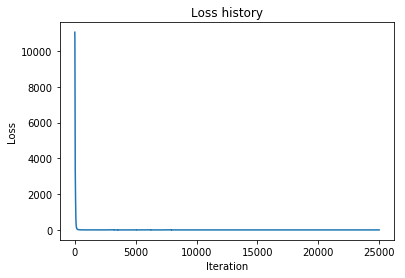

Test:
X_test:  
1.00000e-02 *
 -8.2110
 -6.7737
  4.1496
[torch.FloatTensor of size 3x1]

y_pred:  Variable containing:
 -5.0098
 -0.0103
 37.9884
[torch.FloatTensor of size 3x1]



In [223]:
model = torch.nn.Sequential(OrderedDict([
            ("Pow123Net", Pow123Net()),
            ("FC", torch.nn.Linear(3, 1))]
        ))
RunV2NNTraining(X=X_norm_tsr.view(-1,1), y=y_tensor, model=model, batch_size=None, epochs=25000, learning_rate=1e-1, 
                    X_test=X_test_norm_tsr.view(-1,1), use_optimizer='Adam')